In [1]:
import numpy as np
import pickle
import tensorflow as tf
import optuna
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load datasets
with open('digit_0_train.pkl', 'rb') as f:
    digit_0_train = pickle.load(f)  # List of tuples (image, label)

with open('full_test.pkl', 'rb') as f:
    full_test = pickle.load(f)  # Tuple (x_test, y_test)

full_test_images, full_test_labels = full_test
zero_train_images, zero_train_labels = zip(*digit_0_train)

# Reshape data to be 28x28x1 and normalize pixel values
zero_train_images = np.array(zero_train_images).reshape((-1, 28, 28, 1)) / 255.0
zero_train_labels = np.array(zero_train_labels)
test_images = np.array(full_test_images).reshape((-1, 28, 28, 1)) / 255.0
test_labels = np.array(full_test_labels)

In [ ]:
base_model = load_model('base_cnn_model.keras')
base_model.summary()

In [4]:
class LoRADense(layers.Layer):
    def __init__(self, units, rank=4, **kwargs):
        super().__init__(**kwargs) 
        self.units = units  # Output diminsion of origional weight matrix
        self.rank = rank  # Rank for LoRA

    def build(self, input_shape):
        input_dim = input_shape[-1]  # Get the input dimension from the shape

        # Create a base Dense layer that is frozen
        self.base_dense = layers.Dense(self.units, use_bias=False, trainable=False)
        self.base_dense.build(input_shape)

        # Initialize LoRA trainable parameters
        self.lora_A = self.add_weight(
            shape=(input_dim, self.rank), initializer="random_normal", trainable=True, name="lora_A"
        )  # LoRA A matrix
        self.lora_B = self.add_weight(
            shape=(self.rank, self.units), initializer="random_normal", trainable=True, name="lora_B"
        )  # LoRA B matrix

        # Strength factor for LoRA contribution
        self.alpha = self.add_weight(shape=(), initializer="ones", trainable=True, name="alpha")

    def call(self, inputs):
        # Base layer output
        base_output = self.base_dense(inputs)
        
        # Calculate the LoRA contribution
        lora_output = tf.matmul(tf.matmul(inputs, self.lora_A), self.lora_B) * self.alpha
        
        # Return the combined output of base and LoRA contributions
        return base_output + lora_output

In [5]:
def create_lora_model(base_model, lora_rank=4):
    # Get the layers from the base model
    base_layers = base_model.layers
    
    # Create a new model with LoRA adaptations
    inputs = keras.Input(shape=(28, 28, 1))
    x = inputs
    
    for i, layer in enumerate(base_layers):
        # Apply LoRA to the 8th and 10th layers
        if i in [8, 10] and isinstance(layer, keras.layers.Dense):
            # Create a LoRA version of the layer
            lora_layer = LoRADense(units=layer.units, rank=lora_rank, name=f"lora_{layer.name}")
            lora_layer.build(x.shape)  # Build layer
            lora_layer.base_dense.kernel.assign(layer.kernel)  # Assign original weights after build
            x = lora_layer(x)
        else:
            # Use the original layer
            x = layer(x)
    
    lora_model = keras.Model(inputs, x)
    
    # Freeze all layers except the LoRA parameters
    for layer in lora_model.layers:
        if not isinstance(layer, LoRADense):
            layer.trainable = False
    
    return lora_model

In [ ]:
def objective(trial):    
    model = create_lora_model(base_model)
    
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', .0000001, .0001, log=True)
    epochs = trial.suggest_int('epochs', 5, 30)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    history = model.fit(
        zero_train_images, zero_train_labels,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0 
    )
    
    # Evaluate on test set
    _, test_acc = model.evaluate(test_images, test_labels, verbose=0)
    
    return test_acc

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value:.4f}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [7]:
# Create the LoRA model using best parameters from Optuna study
model = create_lora_model(base_model)

best_lr = study.best_params['learning_rate']
best_epochs = study.best_params['epochs']

model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    zero_train_images, zero_train_labels,
    epochs=best_epochs,
    validation_split=0.2,
    callbacks=[early_stopping]
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9744 - loss: 0.1414
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Full test accuracy: 0.9774
Accuracy for digit 0: 0.9673


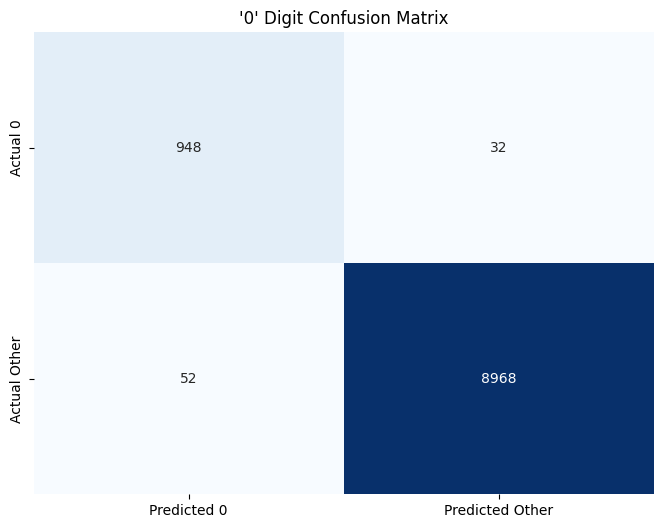

In [10]:
# Full test accuracy
_, test_acc = model.evaluate(test_images, test_labels)

# Accuracy for just digit '0'
# Get predictions for all test data
y_pred = np.argmax(model.predict(test_images), axis=1)

# Find indices of digit '0' in test set
zero_indices = np.where(test_labels == 0)[0]
zero_images = test_images[zero_indices]
zero_true_labels = test_labels[zero_indices]

# Get predictions for digit '0' samples
zero_pred = np.argmax(model.predict(zero_images), axis=1)

# Calculate accuracy for digit '0'
zero_accuracy = accuracy_score(zero_true_labels, zero_pred)

print(f'Full test accuracy: {test_acc:.4f}')
print(f'Accuracy for digit 0: {zero_accuracy:.4f}')

# Calculate number of false positives, false negatives, true positives, and true negatives for digit '0'
false_positives = np.sum((y_pred == 0) & (test_labels != 0))
false_negatives = np.sum((y_pred != 0) & (test_labels == 0))
true_positives = np.sum((y_pred == 0) & (test_labels == 0))
true_negatives = np.sum((y_pred != 0) & (test_labels != 0))

# Set up confusion matrix structure
conf_matrix = np.array([[true_positives, false_negatives], [false_positives, true_negatives]])

# Create confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted Other'], 
            yticklabels=['Actual 0', 'Actual Other'], 
            cbar=False)
plt.title("'0' Digit Confusion Matrix")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9663 - loss: 0.1615
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LoRA strength: 0.8, Full accuracy: 0.9672, Digit 0 accuracy: 0.8163
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9713 - loss: 0.1464
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LoRA strength: 0.85, Full accuracy: 0.9728, Digit 0 accuracy: 0.8806
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9734 - loss: 0.1385
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LoRA strength: 0.9, Full accuracy: 0.9755, Digit 0 accuracy: 0.9173
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9735 - loss: 0.1360
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LoRA strength: 0.95, Full accuracy: 0.9763, Digit 0 accuracy: 0.9398
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9748 - loss: 0.1379
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LoRA strength: 1.0, Full accuracy: 0.9775, Digit 0 accuracy: 0.9592
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9737 - loss: 0.1437
31/31 ━━━━━━━

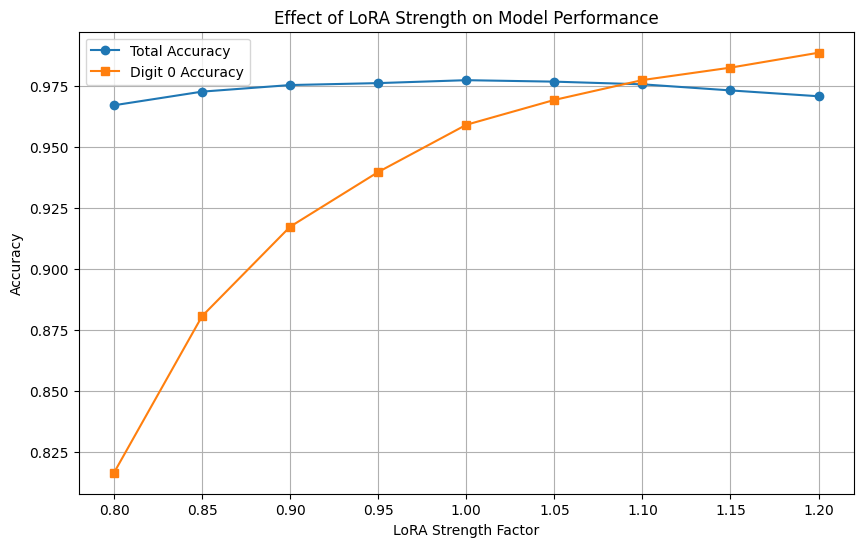

In [11]:
# Function to adjust the strength of LoRA
# Note that accuracy results using a strength of 1 will differ from the origional model due to alpha being a trainable parameter
def adjust_lora_strength(model, strength_factor):
    for layer in model.layers:
        if isinstance(layer, LoRADense):
            layer.alpha.assign(strength_factor)
    return model

# Test different LoRA strengths
strengths = [.8, .85, .9, .95, 1.0, 1.05, 1.1, 1.15, 1.2]
results = []

for strength in strengths:
    # Adjust LoRA strength
    adjusted_model = adjust_lora_strength(model, strength)
    
    # Evaluate
    test_loss, test_acc = adjusted_model.evaluate(test_images, test_labels)
    
    # Get predictions for digit '0'
    zero_indices = np.where(test_labels == 0)[0]
    zero_images = test_images[zero_indices]
    zero_true_labels = test_labels[zero_indices]
    zero_pred = np.argmax(adjusted_model.predict(zero_images), axis=1)
    zero_accuracy = accuracy_score(zero_true_labels, zero_pred)
    
    results.append((strength, test_acc, zero_accuracy))
    print(f'LoRA strength: {strength}, Full accuracy: {test_acc:.4f}, Digit 0 accuracy: {zero_accuracy:.4f}')

# Plot results
plt.figure(figsize=(10, 6))
strengths, full_accs, zero_accs = zip(*results)
plt.plot(strengths, full_accs, 'o-', label='Total Accuracy')
plt.plot(strengths, zero_accs, 's-', label='Digit 0 Accuracy')
plt.xlabel('LoRA Strength Factor')
plt.ylabel('Accuracy')
plt.title('Effect of LoRA Strength on Model Performance')
plt.legend()
plt.grid(True)
plt.show()